The following program calculates the emotions from a sentence. we've used the emotions lexicons published by NRC. It basically looks up for a word in the attached lexicon and returns one of the six emotions it is attached to. It further aggregates the data and plots the bar chart with the overall emotion score of the file.

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import csv
import string
#from textblob import TextBlob as blob
from scipy import stats

from datetime import datetime, timedelta
from matplotlib import style
# text parsing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import TweetTokenizer
import sys
non_bmp_map = dict.fromkeys(range(0x10000, sys.maxunicode + 1), 0xfffd)

style.use('ggplot')

In [37]:
dt = pd.read_csv(r'C:\Users\Tushar pc\Desktop\HackOnData\Sentiment Analysis\Amazon_reviews.csv', header=0)
dt.head()

,Unnamed: 0,helpful,overall,reviewerID,reviewText,summary,asin,reviewTime,unixReviewTime,reviewerName
0,0,"[4, 4]",4.0,A1JZFGZEZVWQPY,Good USA company that stands behind their prod...,Great Hoses,B00002N674,"06 21, 2011",1308614400,"Carter H ""1amazonreviewer@gmail . com"""
1,1,"[0, 0]",5.0,A32JCI4AK2JTTG,This is a high quality 8 ply hose. I have had ...,Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,B00002N674,"06 9, 2014",1402272000,"Darryl Bennett ""Fuzzy342"""
2,2,"[2, 3]",4.0,A3N0P5AAMP6XD2,It's probably one of the best hoses I've ever ...,Very satisfied!,B00002N674,"05 5, 2012",1336176000,H B
3,3,"[0, 0]",5.0,A2QK7UNJ857YG,I probably should have bought something a bit ...,Very high quality,B00002N674,"07 15, 2013",1373846400,Jason
4,4,"[1, 1]",5.0,AS0CYBAN6EM06,I bought three of these 5/8-inch Flexogen hose...,Good Hoses,B00002N674,"08 5, 2013",1375660800,jimmy


In [38]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

In [39]:
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

In [40]:
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

In [41]:
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [44]:
dt['reviewText'] = dt['reviewText'].astype(str)

tweettext = dt['reviewText']
tweettext = tweettext.replace({r"(?:\@|https?\://)\S+": ""}, regex=True)

In [45]:
dt.loc[:, 'sentences'] = dt.loc[:, 'reviewText'].apply(sent_tokenize)
dt.loc[:, 'tokens']    = dt.loc[:, 'reviewText'].apply(preprocess)

In [46]:
emotion_lexicon = pd.read_csv(r'C:\Users\Tushar pc\Desktop\HackOnData\Sentiment Analysis\NRC_Emotion_Lexicon_2.csv', header=0)
emotion_lexicon[1:20]

,English Word,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
1,abacus,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,1,0
5,abate,0,0,0,0,0,0,0,0
6,abatement,0,0,0,0,0,0,0,0
7,abba,0,0,0,0,0,0,0,0
8,abbot,0,0,0,0,0,0,0,1
9,abbreviate,0,0,0,0,0,0,0,0
10,abbreviation,0,0,0,0,0,0,0,0


In [47]:
affects = ['Anger', 'Anticipation', 'Disgust',
           'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']

In [48]:
emotion_words = dict()
for key in affects:
    emotion_words[key] = emotion_lexicon[(emotion_lexicon[key] == 1)]['English Word'].tolist()

In [49]:
def emotioncount(df, emotion):
    col = []
    for line in df:
        emotcount = 0
        for word in line:
            if word in emotion_words[emotion]:
                emotcount = emotcount + 1
        col.append(emotcount)
    return col

In [50]:
### how many tokens (words) in each tweet? create a column specifying this
dt.loc[:, 'number of tokens'] = dt['tokens'].apply(len)
##
### for each emotion, create a column with the number of words matching that emotion in a given tweet, then a ratio of the number of words
### matching that emotion against the total number of words in the tweet
for affect in affects:
    dt.loc[:, affect] = emotioncount(dt['tokens'], affect)
    dt.loc[:, affect + " ratio"] = dt[affect] / dt['number of tokens']

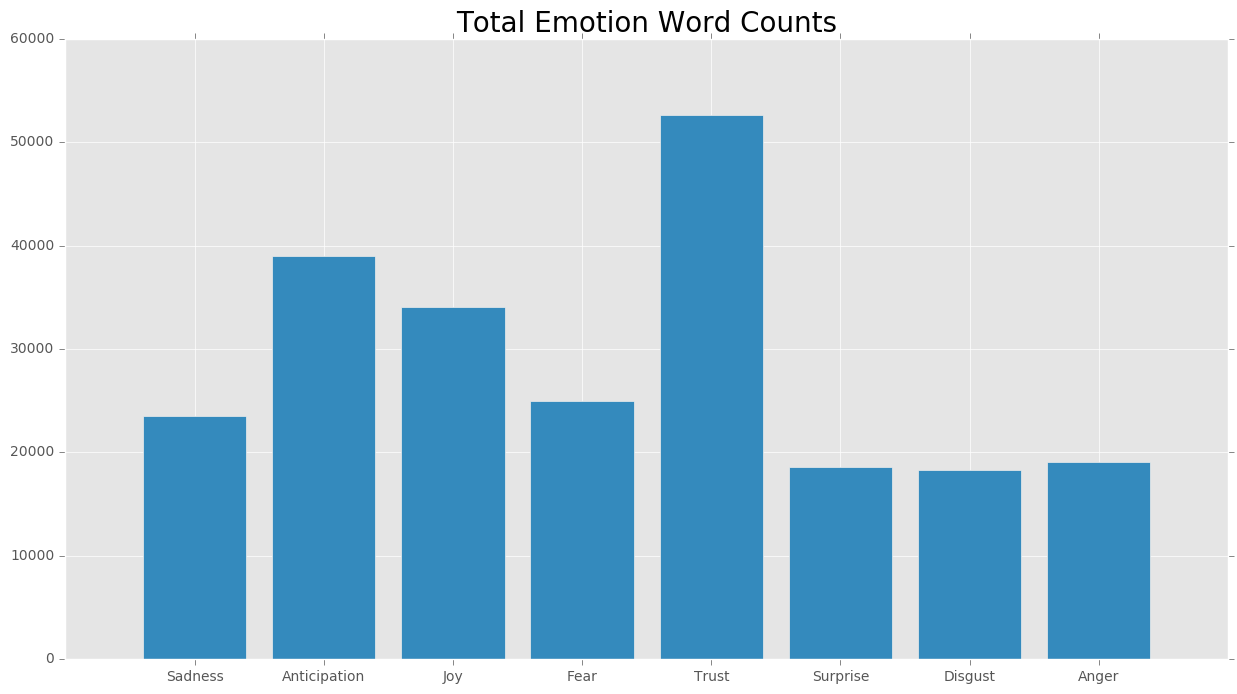

In [51]:
emotion_sums = dict()
for key in affects:
    emotion_sums[key] = sum(dt[key])

plt.figure(figsize=(15,8))
plt.title('Total Emotion Word Counts', fontsize = 20)
plt.bar(range(len(emotion_sums)), emotion_sums.values(), align='center', )
plt.xticks(range(len(emotion_sums)), emotion_sums.keys())

plt.show()